In [1]:
import networkx as nx
import numpy as np
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain
from collections import defaultdict
from gensim.models import Word2Vec
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

# Pipeline

### Data Loader

We need to load networks into memory. Usually networks are organized as pairs of nodes. And sometimes different edges have different weights. Hence, we use networkx.DiGraph to store such structure information and attributes.

In [2]:
def load_data(file_name):
    """
    read edges from an edge file
    """
    edges = list()
    df = pd.read_csv(file_name)
    for idx, row in df.iterrows():
        user_id, friends = row["user_id"], eval(row["friends"])
        for friend in friends:
            # add each friend relation as an edge
            edges.append((user_id, friend))
    edges = sorted(edges)
    
    return edges

def load_test_data(file_name):
    """
    read edges from an edge file
    """
    edges = list()
    scores = list()
    df = pd.read_csv(file_name)
    for idx, row in df.iterrows():
        edges.append((row["src"], row["dst"]))
    edges = sorted(edges)
    
    return edges

def generate_false_edges(true_edges, num_false_edges=5):
    """
    generate false edges given true edges
    """
    nodes = list(set(chain.from_iterable(true_edges)))
    N = len(nodes)
    true_edges = set(true_edges)
    print(N, len(true_edges))
    false_edges = set()
    
    while len(false_edges) < num_false_edges:
        # randomly sample two different nodes and check whether the pair exisit or not
        src, dst = nodes[int(np.random.rand() * N)], nodes[int(np.random.rand() * N)]
        if src != dst and (src, dst) not in true_edges and (src, dst) not in false_edges:
            false_edges.add((src, dst))
    false_edges = sorted(false_edges)
    
    return false_edges

def construct_graph_from_edges(edges):
    """
    generate a directed graph object given true edges
    DiGraph documentation: https://networkx.github.io/documentation/stable/reference/classes/digraph.html
    """
    # convert a list of edges {(u, v)} to a list of edges with weights {(u, v, w)}
    edge_weight = defaultdict(float)
    for e in edges:
        edge_weight[e] += 1.0
    weighed_edge_list = list()
    for e in sorted(edge_weight.keys()):
        weighed_edge_list.append((e[0], e[1], edge_weight[e]))
        
    graph = nx.DiGraph()
    graph.add_weighted_edges_from(weighed_edge_list)
    
    print("number of nodes:", graph.number_of_nodes())
    print("number of edges:", graph.number_of_edges())
    
    return graph

### Random Walk Generator

Random walk generators or random walkers yield random walks that contain both local and higher-order neighborhood information. However, naive non-uniform sampling is very slow, which requires O(n) time complexity. Here alias sampling can reduce the time complexity to O(1) with O(n) space. If you are interested, please see the following blog.

In [3]:
def alias_setup(probs):
    """
    compute utility lists for non-uniform sampling from discrete distributions.
    details: https://lips.cs.princeton.edu/the-alias-method-efficient-sampling-with-many-discrete-outcomes/
    """
    K = len(probs)
    q = np.zeros(K)
    J = np.zeros(K, dtype=np.int)

    smaller = list()
    larger = list()
    for kk, prob in enumerate(probs):
        q[kk] = K * prob
        if q[kk] < 1.0:
            smaller.append(kk)
        else:
            larger.append(kk)

    while len(smaller) > 0 and len(larger) > 0:
        small = smaller.pop()
        large = larger.pop()

        J[small] = large
        q[large] = q[large] + q[small] - 1.0
        if q[large] < 1.0:
            smaller.append(large)
        else:
            larger.append(large)

    return J, q

def get_alias_node(graph, node):
    """
    get the alias node setup lists for a given node.
    """
    # get the unnormalized probabilities with the first-order information
    unnormalized_probs = list()
    for nbr in graph.neighbors(node):
        unnormalized_probs.append(graph[node][nbr]["weight"])
    unnormalized_probs = np.array(unnormalized_probs)
    if len(unnormalized_probs) > 0:
        normalized_probs = unnormalized_probs / unnormalized_probs.sum()
    else:
        normalized_probs = unnormalized_probs
        
    return alias_setup(normalized_probs)
    
def get_alias_edge(graph, src, dst, p=1, q=1):
    """
    get the alias edge setup lists for a given edge.
    """
    # get the unnormalized probabilities with the second-order information
    unnormalized_probs = list()
    for dst_nbr in graph.neighbors(dst):
        if dst_nbr == src: # distance is 0
            unnormalized_probs.append(graph[dst][dst_nbr]["weight"]/p)
        elif graph.has_edge(dst_nbr, src): # distance is 1
            unnormalized_probs.append(graph[dst][dst_nbr]["weight"])
        else: # distance is 2
            unnormalized_probs.append(graph[dst][dst_nbr]["weight"]/q)
    unnormalized_probs = np.array(unnormalized_probs)
    if len(unnormalized_probs) > 0:
        normalized_probs = unnormalized_probs / unnormalized_probs.sum()
    else:
        normalized_probs = unnormalized_probs

    return alias_setup(normalized_probs)

def preprocess_transition_probs(graph, p=1, q=1):
    """
    preprocess transition probabilities for guiding the random walks.
    """
    alias_nodes = dict()
    for node in graph.nodes():
        alias_nodes[node] = get_alias_node(graph, node)

    alias_edges = dict()
    for edge in graph.edges():
        alias_edges[edge] = get_alias_edge(graph, edge[0], edge[1], p=p, q=q)

    return alias_nodes, alias_edges

The difference between DeepWalk and node2vec is how to generate random walks. The former only consider the first-order information while the latter also involves the second-order information.

In [4]:
def alias_draw(J, q):
    """
    draw sample from a non-uniform discrete distribution using alias sampling.
    """
    K = len(J)

    kk = int(np.floor(np.random.rand() * K))
    if np.random.rand() < q[kk]:
        return kk
    else:
        return J[kk]


# helper function to generate the long random walk as desired
def fallback(walk, fetch_last_num=1):
    if len(walk) > fetch_last_num:
        walk.pop()
        fetched = []
        for i in range(fetch_last_num):
            fetched.append(walk[-1-i])
        return walk, fetched
    else:
        return [], [None for _ in range(fetch_last_num)]

def generate_first_order_random_walk(graph, alias_nodes, 
                                     walk_length=10, start_node=None, verbose=False, max_trails=10):
    """
    simulate a random walk starting from start node and considering the first order information.
    max_trials: set the max trials to be one for standard random walk. Larger max_trails will make the generated biased.
    """
    if start_node == None:
        start_node = np.random.choice(graph.nodes())
    walk = [start_node]
    cur = start_node
    num_tried = 0
    
    ########## begin ##########
    while len(walk) < walk_length:
        cur_nbrs = list(graph.neighbors(cur))
        if len(cur_nbrs) > 0: # if we can sample next nodes
            # sample the next node based on alias_nodes
            cur = cur_nbrs[alias_draw(*alias_nodes[cur])]
            walk.append(cur)
        else: # if we can't do that
            num_tried += 1
            if num_tried >= max_trails:
                break

            walk, fetched = fallback(walk, fetch_last_num=1)
            cur = fetched[0]
            if len(walk) == 0: # if falls back to the empty walk
                start_node = np.random.choice(graph.nodes())
                walk = [start_node]
                cur = start_node
    ########## end ##########

    if verbose: 
        print(f'walk of lenght {len(walk)} generated with {num_tried} trails')
    return walk
    
def generate_second_order_random_walk(graph, alias_nodes, alias_edges, 
                                      walk_length=10, start_node=None, verbose=False, max_trails=10):
    """
    simulate a random walk starting from start node and considering the second order information.
    """
    if start_node == None:
        start_node = np.random.choice(graph.nodes())
    walk = [start_node]
    
    prev = None
    cur = start_node
    num_tried = 0

    ########## begin ##########
    while len(walk) < walk_length:
        cur_nbrs = list(graph.neighbors(cur))
        if len(cur_nbrs) > 0:
            if prev is None:
                # sample the next node based on alias_nodes
                prev, cur = cur, cur_nbrs[alias_draw(*alias_nodes[cur])]
            else:
                # sample the next node based on alias_edges
                prev, cur = cur, cur_nbrs[alias_draw(*alias_edges[(prev, cur)])]
            walk.append(cur)
        else:
            num_tried += 1
            if num_tried >= max_trails:
                break
            walk, (cur, prev) = fallback(walk, fetch_last_num=2)
            if len(walk) == 0:
                start_node = np.random.choice(graph.nodes())
                walk = [start_node]
                cur = start_node
                prev = None
    ########## end ##########
    if verbose: 
        print(f'walk of lenght {len(walk)} generated with {num_tried} trails')
    return walk

### Network Embedding Algorithms

In [29]:
def build_deepwalk(graph, alias_nodes, node_dim=10, num_walks=10, walk_length=10):
    """
    build a deepwalk model
    """
    print("building a DeepWalk model...", end="\t")
    st = time.time()
    np.random.seed(0)
    nodes = list(graph.nodes())
    walks = list()
    # generate random walks
    for walk_iter in range(num_walks):
        np.random.shuffle(nodes)
        for node in nodes:
            walks.append(generate_first_order_random_walk(
                graph, alias_nodes, walk_length=walk_length, start_node=node))
        
    walk_lens = [len(w) for w in walks]
    if len(walk_lens) > 0:
        avg_walk_len = sum(walk_lens) / len(walk_lens)
    else:
        avg_walk_len = 0.0
    print("number of walks: %d\taverage walk length: %.4f" % (len(walks), avg_walk_len), end="\t")
    
    # train a skip-gram model for these walks
    model = Word2Vec(walks, size=node_dim, window=3, min_count=0, sg=1, workers=os.cpu_count(), iter=10)
    print("training time: %.4f" % (time.time()-st))
    
    return model

def build_node2vec(graph, alias_nodes, alias_edges, node_dim=10, num_walks=10, walk_length=10, p=0.5, q=0.5):
    """
    build a node2vec model
    """
    print("building a node2vec model...", end="\t")
    st = time.time()
    np.random.seed(0)
    nodes = list(graph.nodes())
    walks = list()
    # generate random walks
    for walk_iter in range(num_walks):
        np.random.shuffle(nodes)
        for node in nodes:
            walks.append(generate_second_order_random_walk(
                graph, alias_nodes, alias_edges, walk_length=walk_length, start_node=node))
            
    walk_lens = [len(w) for w in walks]
    if len(walk_lens) > 0:
        avg_walk_len = sum(walk_lens) / len(walk_lens)
    else:
        avg_walk_len = 0.0    
    print("number of walks: %d\taverage walk length: %.4f" % (len(walks), avg_walk_len), end="\t")
    
    # train a skip-gram model for these walks
    model = Word2Vec(walks, size=node_dim, window=3, min_count=0, sg=1, workers=os.cpu_count(), iter=10)
    print("training time: %.4f" % (time.time()-st))
    
    return model

### Scorer

In [6]:
def get_cosine_sim(model, u, v):
    """
    get the cosine similarity between two nodes
    """
    try:
        u = model.wv[u]
        v = model.wv[v]
        return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))
    except:
        return 0.5

def get_auc_score(model, true_edges, false_edges):
    """
    get the auc score
    """
    y_true = [1] * len(true_edges) + [0] * len(false_edges)
    
    y_score = list()
    for e in true_edges:
        y_score.append(get_cosine_sim(model, e[0], e[1]))
    for e in false_edges:
        y_score.append(get_cosine_sim(model, e[0], e[1]))
    
    return roc_auc_score(y_true, y_score)

def write_pred(file_name, edges, scores):
    df = pd.DataFrame()
    df["src"] = [e[0] for e in edges]
    df["dst"] = [e[1] for e in edges]
    df["score"] = scores
    df.to_csv(file_name, index=False)

def write_valid_ans(file_name, edges, scores):
    df = pd.DataFrame()
    df["src"] = [e[0] for e in edges]
    df["dst"] = [e[1] for e in edges]
    df["score"] = scores
    df.to_csv(file_name, index=False)

### Try them over a Real-life Network

Firstly, we need to load edges into memory and use the networkx.DiGraph structure to store the graph.

In [7]:
train_file = "train.csv"
valid_file = "valid.csv"
test_file = "test.csv"

np.random.seed(0)
train_edges = load_data(train_file)
graph = construct_graph_from_edges(train_edges)
valid_edges = load_data(valid_file)
false_edges = generate_false_edges(train_edges+valid_edges, 40000-len(valid_edges))
test_edges = load_test_data(test_file)

number of nodes: 8343
number of edges: 100000
8496 119267


After that, we can use preprocess transition probabilities with the help of alias sampling.

In [22]:
alias_nodes, alias_edges = preprocess_transition_probs(graph, p=0.5, q=0.5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


We can use random walk generators to generate random walks.

Let's try to generate a first-order random walk and a second-order random walk.

In [18]:
generate_first_order_random_walk(graph, alias_nodes=alias_nodes,
                                 start_node="N6ZTMIue-2b30CJv2tyPGg", walk_length=10)

['N6ZTMIue-2b30CJv2tyPGg',
 'hfoQz3eUkASnf3bs7AdbuA',
 'VvLhL1THnDwNNWlP4ydv8g',
 'lSgRHaq1uGMMC9WGfnipMQ',
 'soc2J5OHH7V6JQ7t211Icg',
 'rzq5nqG2NG13o3ISxJSrsQ',
 'w1TjcJ6itK7LC_IY61NQIQ',
 '1uVmN3vSvxCrxijXFwtIrA',
 'FaAb-CoKW4xDvLTSPtEbgw',
 'dXEp1pbm0i2iAZ8Ifnpu7Q']

In [19]:
generate_second_order_random_walk(graph, alias_nodes=alias_nodes, alias_edges=alias_edges,
                                  start_node="N6ZTMIue-2b30CJv2tyPGg", walk_length=10)

['N6ZTMIue-2b30CJv2tyPGg',
 'fDBybzZAL5UDscd33HCXyA',
 'f__9p6lo6hmwnAEh3yorsQ',
 's76BDmBx_8kcxGFDiU6k_g',
 'zFYs8gSUYDvXkb6O7YkRkw',
 'n8sxD3ybFwCHhOo9P3bVhw',
 'UGlYryF2DKbmBhTa7kq5WQ',
 'jD9S1crLvnAxzYEG_r_NOA',
 'e6iCOIhtupBCiw-VwBvJ4A',
 '6AMwQ8cFWIKGbGpVwehkfw']

And we can build a DeepWalk model and a node2vec model. Here we set p=q=0.5 so that the walker will not go very far away from the start node.

In [23]:
# provided 
model = build_deepwalk(graph, alias_nodes, node_dim=10, num_walks=10, walk_length=10)

building a DeepWalk model...	number of walks: 83430	average walk length: 9.8905	training time: 55.7138


In [24]:
# provided 
model = build_node2vec(graph, alias_nodes, alias_edges, node_dim=10, num_walks=10, walk_length=10)

building a node2vec model...	number of walks: 83430	average walk length: 9.9949	training time: 56.9370


Let's see the node embeddings of three nodes, and cosine similarities of two edges.

In [13]:
# provided

print("node embedding (\"N6ZTMIue-2b30CJv2tyPGg\"):",
      model.wv["N6ZTMIue-2b30CJv2tyPGg"])
print("node embedding (\"N7E-CfqdME28dakWdEKNvw\"):",
      model.wv["N7E-CfqdME28dakWdEKNvw"])
print("node embedding (\"MmlJSLDg-IFaeXb5wdJbgg\"):",
      model.wv.vectors[model.wv.index2word.index("MmlJSLDg-IFaeXb5wdJbgg")])
print("true edge (\"N6ZTMIue-2b30CJv2tyPGg\", \"N7E-CfqdME28dakWdEKNvw\"):",
      get_cosine_sim(model, "N6ZTMIue-2b30CJv2tyPGg", "N7E-CfqdME28dakWdEKNvw"))
print("false edge (\"N6ZTMIue-2b30CJv2tyPGg\", \"MmlJSLDg-IFaeXb5wdJbgg\"):",
      get_cosine_sim(model, "N6ZTMIue-2b30CJv2tyPGg", "MmlJSLDg-IFaeXb5wdJbgg"))

node embedding ("N6ZTMIue-2b30CJv2tyPGg"): [ 0.03688295  0.08125529 -0.15754741  0.2129002   0.8215821   0.26379225
 -0.65750664  1.1600795   1.9026272  -1.5282927 ]
node embedding ("N7E-CfqdME28dakWdEKNvw"): [-0.05767223 -0.63923293  0.352904    0.5136198   0.20613359  0.6216189
 -0.93747264  1.1409135   1.394362   -1.2782726 ]
node embedding ("MmlJSLDg-IFaeXb5wdJbgg"): [-0.57771724 -0.5854629   1.1915958  -0.57528263 -0.62071437  2.3960955
 -1.4660178   1.1655767  -1.4041474  -2.0564406 ]
true edge ("N6ZTMIue-2b30CJv2tyPGg", "N7E-CfqdME28dakWdEKNvw"): 0.88968
false edge ("N6ZTMIue-2b30CJv2tyPGg", "MmlJSLDg-IFaeXb5wdJbgg"): 0.20242235


In [25]:
deepwalk = build_deepwalk(graph, alias_nodes, node_dim=10, num_walks=10, walk_length=10)
node2vec = build_node2vec(graph, alias_nodes, alias_edges, node_dim=10, num_walks=10, walk_length=10)

building a DeepWalk model...	number of walks: 83430	average walk length: 9.8905	training time: 53.2526
building a node2vec model...	number of walks: 83430	average walk length: 9.9949	training time: 43.6902


In [26]:
print('--- Deepwalk (1st order random walk) ---')
print("node embedding (\"N6ZTMIue-2b30CJv2tyPGg\"):",
      deepwalk.wv["N6ZTMIue-2b30CJv2tyPGg"])
print("node embedding (\"N7E-CfqdME28dakWdEKNvw\"):",
      deepwalk.wv["N7E-CfqdME28dakWdEKNvw"])
print("node embedding (\"MmlJSLDg-IFaeXb5wdJbgg\"):",
      deepwalk.wv["MmlJSLDg-IFaeXb5wdJbgg"])
print("true edge (\"N6ZTMIue-2b30CJv2tyPGg\", \"N7E-CfqdME28dakWdEKNvw\"):",
      get_cosine_sim(deepwalk, "N6ZTMIue-2b30CJv2tyPGg", "N7E-CfqdME28dakWdEKNvw"))
print("false edge (\"N6ZTMIue-2b30CJv2tyPGg\", \"MmlJSLDg-IFaeXb5wdJbgg\"):",
      get_cosine_sim(deepwalk, "N6ZTMIue-2b30CJv2tyPGg", "MmlJSLDg-IFaeXb5wdJbgg"))

print()
print('--- Node2Vec (2nd order random walk) ---')
print("node embedding (\"N6ZTMIue-2b30CJv2tyPGg\"):",
      node2vec.wv["N6ZTMIue-2b30CJv2tyPGg"])
print("node embedding (\"N7E-CfqdME28dakWdEKNvw\"):",
      node2vec.wv["N7E-CfqdME28dakWdEKNvw"])
print("node embedding (\"MmlJSLDg-IFaeXb5wdJbgg\"):",
      node2vec.wv["MmlJSLDg-IFaeXb5wdJbgg"])
print("true edge (\"N6ZTMIue-2b30CJv2tyPGg\", \"N7E-CfqdME28dakWdEKNvw\"):",
      get_cosine_sim(node2vec, "N6ZTMIue-2b30CJv2tyPGg", "N7E-CfqdME28dakWdEKNvw"))
print("false edge (\"N6ZTMIue-2b30CJv2tyPGg\", \"MmlJSLDg-IFaeXb5wdJbgg\"):",
      get_cosine_sim(node2vec, "N6ZTMIue-2b30CJv2tyPGg", "MmlJSLDg-IFaeXb5wdJbgg"))

--- Deepwalk (1st order random walk) ---
node embedding ("N6ZTMIue-2b30CJv2tyPGg"): [ 0.3128012   0.2940561   0.4961249  -0.01249413 -0.546018    0.78414893
 -0.42982525  1.3633423   1.3536566  -2.4320655 ]
node embedding ("N7E-CfqdME28dakWdEKNvw"): [ 0.15076956 -0.4034227   0.14650738  0.35950363 -0.6274149   0.40517232
 -0.9226663   1.6286306   0.9349478  -1.4372618 ]
node embedding ("MmlJSLDg-IFaeXb5wdJbgg"): [-1.2840531  -1.7354813  -0.11950085 -0.19090198 -0.19574614  1.9590421
 -1.2779491   1.4825568  -1.7691836  -1.4602005 ]
true edge ("N6ZTMIue-2b30CJv2tyPGg", "N7E-CfqdME28dakWdEKNvw"): 0.8889566
false edge ("N6ZTMIue-2b30CJv2tyPGg", "MmlJSLDg-IFaeXb5wdJbgg"): 0.3136746

--- Node2Vec (2nd order random walk) ---
node embedding ("N6ZTMIue-2b30CJv2tyPGg"): [ 1.0435069  -0.87954175 -0.5103851   0.4268786   0.0022684   0.5267925
 -0.54150504  1.1976777   1.6130556  -1.4772118 ]
node embedding ("N7E-CfqdME28dakWdEKNvw"): [ 0.0728718  -0.6223826   0.06214952  0.18730667 -0.06072151  0

p and q are set as 0.5, and other parameters set as 10. By comparing the true edges and false edges similarity reported by Deepwalk and Node2Vec, we can see that Node2Vec is capable of embedding true edges with higher similarity, and false edges with lower similarity than Deepwalk, and therefore Node2Vec is considered as a better model.

# Link Prediction

Link prediction is a task to prediction unseen edges based on graph information. Let's use cross validation to check their performance in the link prediction task.



We can train the model with different parameters and test the model on the validation set. Please show your parameter search process and analysis in your code, and visualization tools (Heatmap, etc.) are recommended to make your analysis clear.

In [14]:
# Deepwalk
np.random.seed(0)

node_dim = 10
num_walks_list = [5, 10, 20, 40]
walk_length_list = [10, 20, 40]
#walk_length in [10, 20, 40]] for num_walks in [5, 10, 20, 40]
deepwalk_auc_scores = dict()
for num_walks in num_walks_list:
    for walk_length in walk_length_list:
        print("node dim: %d,\tnum_walks: %d,\twalk_length: %d" % (node_dim, num_walks, walk_length), end="\t")
        model = build_deepwalk(graph, alias_nodes, 
                       node_dim=node_dim, num_walks=num_walks, walk_length=walk_length)
        deepwalk_auc_scores[(node_dim, num_walks, walk_length)] = get_auc_score(model, valid_edges, false_edges)
        print("auc: %.4f" % (deepwalk_auc_scores[(node_dim, num_walks, walk_length)]))

node dim: 10,	num_walks: 5,	walk_length: 10	building a DeepWalk model...	number of walks: 41715	average walk length: 9.8900	training time: 20.9801
auc: 0.9105
node dim: 10,	num_walks: 5,	walk_length: 20	building a DeepWalk model...	number of walks: 41715	average walk length: 19.7358	training time: 35.7713
auc: 0.9274
node dim: 10,	num_walks: 5,	walk_length: 40	building a DeepWalk model...	number of walks: 41715	average walk length: 39.4144	training time: 64.7654
auc: 0.9301
node dim: 10,	num_walks: 10,	walk_length: 10	building a DeepWalk model...	number of walks: 83430	average walk length: 9.8905	training time: 39.8690
auc: 0.9278
node dim: 10,	num_walks: 10,	walk_length: 20	building a DeepWalk model...	number of walks: 83430	average walk length: 19.7383	training time: 69.4083
auc: 0.9326
node dim: 10,	num_walks: 10,	walk_length: 40	building a DeepWalk model...	number of walks: 83430	average walk length: 39.4114	training time: 127.6342
auc: 0.9312
node dim: 10,	num_walks: 20,	walk_leng

In [33]:
# Node2Vec: num_walks & walk_length
np.random.seed(0)

node_dim = 10

num_walks_list = [5, 10, 20, 40]
walk_length_list = [10, 20, 40]

p = 0.5
q = 0.5

#walk_length in [10, 20, 40]] for num_walks in [5, 10, 20, 40]
node2vec_auc_scores = dict()
for num_walks in num_walks_list:
    for walk_length in walk_length_list:
        print("node dim: %d,\tnum_walks: %d,\twalk_length: %d,\tp: %.2f,\tq: %.2f" % (node_dim, num_walks, walk_length, p, q), end="\t")
        alias_nodes, alias_edges = preprocess_transition_probs(graph, p=p, q=q)
        model = build_node2vec(graph, alias_nodes, alias_edges, node_dim=node_dim, num_walks=num_walks, walk_length=walk_length)
        node2vec_auc_scores[(node_dim, num_walks, walk_length, p, q)] = get_auc_score(model, valid_edges, false_edges)
        print("auc: %.4f" % (node2vec_auc_scores[(node_dim, num_walks, walk_length, p, q)]))

node dim: 10,	num_walks: 5,	walk_length: 10,	p: 0.50,	q: 0.50	

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


building a node2vec model...	number of walks: 41715	average walk length: 9.9945	training time: 22.6187
auc: 0.9127
node dim: 10,	num_walks: 5,	walk_length: 20,	p: 0.50,	q: 0.50	

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


building a node2vec model...	number of walks: 41715	average walk length: 19.9742	training time: 38.1464
auc: 0.9278
node dim: 10,	num_walks: 5,	walk_length: 40,	p: 0.50,	q: 0.50	

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


building a node2vec model...	number of walks: 41715	average walk length: 39.9133	training time: 68.2596
auc: 0.9307
node dim: 10,	num_walks: 10,	walk_length: 10,	p: 0.50,	q: 0.50	

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


building a node2vec model...	number of walks: 83430	average walk length: 9.9949	training time: 43.4406
auc: 0.9273
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.50,	q: 0.50	

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


building a node2vec model...	number of walks: 83430	average walk length: 19.9733	training time: 74.6632
auc: 0.9320
node dim: 10,	num_walks: 10,	walk_length: 40,	p: 0.50,	q: 0.50	

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


building a node2vec model...	number of walks: 83430	average walk length: 39.9131	training time: 134.9773
auc: 0.9297
node dim: 10,	num_walks: 20,	walk_length: 10,	p: 0.50,	q: 0.50	

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


building a node2vec model...	number of walks: 166860	average walk length: 9.9946	training time: 84.9417
auc: 0.9306
node dim: 10,	num_walks: 20,	walk_length: 20,	p: 0.50,	q: 0.50	

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


building a node2vec model...	number of walks: 166860	average walk length: 19.9756	training time: 145.7051
auc: 0.9316
node dim: 10,	num_walks: 20,	walk_length: 40,	p: 0.50,	q: 0.50	

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


building a node2vec model...	number of walks: 166860	average walk length: 39.9077	training time: 281.5878
auc: 0.9272
node dim: 10,	num_walks: 40,	walk_length: 10,	p: 0.50,	q: 0.50	

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


building a node2vec model...	number of walks: 333720	average walk length: 9.9945	training time: 168.1188
auc: 0.9307
node dim: 10,	num_walks: 40,	walk_length: 20,	p: 0.50,	q: 0.50	

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


building a node2vec model...	number of walks: 333720	average walk length: 19.9746	training time: 288.0201
auc: 0.9284
node dim: 10,	num_walks: 40,	walk_length: 40,	p: 0.50,	q: 0.50	

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


building a node2vec model...	number of walks: 333720	average walk length: 39.9064	training time: 529.0385
auc: 0.9243


In [30]:
# Node2Vec: p & q
np.random.seed(0)

node_dim = 10

num_walks = 10
walk_length = 10

p_list = [0.5, 1, 1.5, 2]
q_list = [0.5, 1, 1.5, 2]

#q in [0.5, 1, 1.5, 2] for p in [0.5, 1, 1.5, 2]
node2vec_auc_scores_pq = dict()
for p in p_list:
    for q in q_list:
        print("node dim: %d,\tnum_walks: %d,\twalk_length: %d,\tp: %.2f,\tq: %.2f" % (node_dim, num_walks, walk_length, p, q), end="\t")
        alias_nodes, alias_edges = preprocess_transition_probs(graph, p=p, q=q)
        model = build_node2vec(graph, alias_nodes, alias_edges, node_dim=node_dim, num_walks=num_walks, walk_length=walk_length, p=p, q=q)
        node2vec_auc_scores_pq[(node_dim, num_walks, walk_length, p, q)] = get_auc_score(model, valid_edges, false_edges)
        print("auc: %.4f" % (node2vec_auc_scores_pq[(node_dim, num_walks, walk_length, p, q)]))

node dim: 10,	num_walks: 10,	walk_length: 10,	p: 0.50,	q: 0.50	

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


building a node2vec model...	number of walks: 83430	average walk length: 9.9949	training time: 46.2362
auc: 0.9263
node dim: 10,	num_walks: 10,	walk_length: 10,	p: 0.50,	q: 1.00	

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


building a node2vec model...	number of walks: 83430	average walk length: 9.9949	training time: 43.6152
auc: 0.9276
node dim: 10,	num_walks: 10,	walk_length: 10,	p: 0.50,	q: 1.50	

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


building a node2vec model...	number of walks: 83430	average walk length: 9.9948	training time: 43.6086
auc: 0.9286
node dim: 10,	num_walks: 10,	walk_length: 10,	p: 0.50,	q: 2.00	

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


building a node2vec model...	number of walks: 83430	average walk length: 9.9955	training time: 43.4628
auc: 0.9289
node dim: 10,	num_walks: 10,	walk_length: 10,	p: 1.00,	q: 0.50	

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


building a node2vec model...	number of walks: 83430	average walk length: 9.9940	training time: 43.7092
auc: 0.9280
node dim: 10,	num_walks: 10,	walk_length: 10,	p: 1.00,	q: 1.00	

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


building a node2vec model...	number of walks: 83430	average walk length: 9.9944	training time: 43.5485
auc: 0.9276
node dim: 10,	num_walks: 10,	walk_length: 10,	p: 1.00,	q: 1.50	

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


building a node2vec model...	number of walks: 83430	average walk length: 9.9939	training time: 43.5705
auc: 0.9294
node dim: 10,	num_walks: 10,	walk_length: 10,	p: 1.00,	q: 2.00	

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


building a node2vec model...	number of walks: 83430	average walk length: 9.9943	training time: 43.4594
auc: 0.9282
node dim: 10,	num_walks: 10,	walk_length: 10,	p: 1.50,	q: 0.50	

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


building a node2vec model...	number of walks: 83430	average walk length: 9.9904	training time: 43.9094
auc: 0.9269
node dim: 10,	num_walks: 10,	walk_length: 10,	p: 1.50,	q: 1.00	

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


building a node2vec model...	number of walks: 83430	average walk length: 9.9940	training time: 43.9141
auc: 0.9277
node dim: 10,	num_walks: 10,	walk_length: 10,	p: 1.50,	q: 1.50	

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


building a node2vec model...	number of walks: 83430	average walk length: 9.9948	training time: 43.7670
auc: 0.9281
node dim: 10,	num_walks: 10,	walk_length: 10,	p: 1.50,	q: 2.00	

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


building a node2vec model...	number of walks: 83430	average walk length: 9.9948	training time: 43.5507
auc: 0.9289
node dim: 10,	num_walks: 10,	walk_length: 10,	p: 2.00,	q: 0.50	

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


building a node2vec model...	number of walks: 83430	average walk length: 9.9893	training time: 44.0231
auc: 0.9267
node dim: 10,	num_walks: 10,	walk_length: 10,	p: 2.00,	q: 1.00	

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


building a node2vec model...	number of walks: 83430	average walk length: 9.9926	training time: 43.6673
auc: 0.9257
node dim: 10,	num_walks: 10,	walk_length: 10,	p: 2.00,	q: 1.50	

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


building a node2vec model...	number of walks: 83430	average walk length: 9.9936	training time: 43.5716
auc: 0.9267
node dim: 10,	num_walks: 10,	walk_length: 10,	p: 2.00,	q: 2.00	

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


building a node2vec model...	number of walks: 83430	average walk length: 9.9948	training time: 47.1357
auc: 0.9284


In [35]:
# Node2Vec: p & q with num_walks = 10, walk_length = 20
np.random.seed(0)

node_dim = 10

num_walks = 10
walk_length = 20

p_list = [0.5, 1, 1.5, 2]
q_list = [0.5, 1, 1.5, 2]

#q in [0.5, 1, 1.5, 2] for p in [0.5, 1, 1.5, 2]
node2vec_auc_scores_pq_2 = dict()
for p in p_list:
    for q in q_list:
        print("node dim: %d,\tnum_walks: %d,\twalk_length: %d,\tp: %.2f,\tq: %.2f" % (node_dim, num_walks, walk_length, p, q), end="\t")
        alias_nodes, alias_edges = preprocess_transition_probs(graph, p=p, q=q)
        model = build_node2vec(graph, alias_nodes, alias_edges, node_dim=node_dim, num_walks=num_walks, walk_length=walk_length, p=p, q=q)
        node2vec_auc_scores_pq_2[(node_dim, num_walks, walk_length, p, q)] = get_auc_score(model, valid_edges, false_edges)
        print("auc: %.4f" % (node2vec_auc_scores_pq_2[(node_dim, num_walks, walk_length, p, q)]))

node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.50,	q: 0.50	

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


building a node2vec model...	number of walks: 83430	average walk length: 19.9733	training time: 75.0517
auc: 0.9316
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.50,	q: 1.00	

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


building a node2vec model...	number of walks: 83430	average walk length: 19.9812	training time: 73.8045
auc: 0.9317
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.50,	q: 1.50	

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


building a node2vec model...	number of walks: 83430	average walk length: 19.9835	training time: 73.9719
auc: 0.9313
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.50,	q: 2.00	

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


building a node2vec model...	number of walks: 83430	average walk length: 19.9829	training time: 73.3260
auc: 0.9314
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 1.00,	q: 0.50	

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


building a node2vec model...	number of walks: 83430	average walk length: 19.9678	training time: 75.2989
auc: 0.9326
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 1.00,	q: 1.00	

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


building a node2vec model...	number of walks: 83430	average walk length: 19.9759	training time: 74.5492
auc: 0.9314
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 1.00,	q: 1.50	

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


building a node2vec model...	number of walks: 83430	average walk length: 19.9797	training time: 73.7373
auc: 0.9328
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 1.00,	q: 2.00	

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


building a node2vec model...	number of walks: 83430	average walk length: 19.9812	training time: 85.6783
auc: 0.9322
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 1.50,	q: 0.50	

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


building a node2vec model...	number of walks: 83430	average walk length: 19.9645	training time: 74.8383
auc: 0.9325
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 1.50,	q: 1.00	

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


building a node2vec model...	number of walks: 83430	average walk length: 19.9732	training time: 74.8381
auc: 0.9320
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 1.50,	q: 1.50	

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


building a node2vec model...	number of walks: 83430	average walk length: 19.9794	training time: 74.1636
auc: 0.9316
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 1.50,	q: 2.00	

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


building a node2vec model...	number of walks: 83430	average walk length: 19.9813	training time: 74.4774
auc: 0.9325
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 2.00,	q: 0.50	

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


building a node2vec model...	number of walks: 83430	average walk length: 19.9509	training time: 74.7653
auc: 0.9323
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 2.00,	q: 1.00	

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


building a node2vec model...	number of walks: 83430	average walk length: 19.9700	training time: 74.8159
auc: 0.9324
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 2.00,	q: 1.50	

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


building a node2vec model...	number of walks: 83430	average walk length: 19.9738	training time: 73.9758
auc: 0.9319
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 2.00,	q: 2.00	

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


building a node2vec model...	number of walks: 83430	average walk length: 19.9762	training time: 73.6846
auc: 0.9328


In [15]:
# provided

np.random.seed(0)

node_dim = 10
num_walks = 10
walk_length = 10
p = 0.5
q = 0.5

node2vec_auc_scores = dict()
print("node dim: %d,\tnum_walks: %d,\twalk_length: %d,\tp: %.2f,\tq: %.2f" % (
    node_dim, num_walks, walk_length, p, q), end="\t")
alias_nodes, alias_edges = preprocess_transition_probs(graph, p=p, q=q)
model = build_node2vec(graph, alias_nodes, alias_edges, 
                       node_dim=node_dim, num_walks=num_walks, walk_length=walk_length)
node2vec_auc_scores[(node_dim, num_walks, walk_length, p, q)] = get_auc_score(model, valid_edges, false_edges)
print("auc: %.4f" % (node2vec_auc_scores[(node_dim, num_walks, walk_length, p, q)]))

node dim: 10,	num_walks: 10,	walk_length: 10,	p: 0.50,	q: 0.50	

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


building a node2vec model...	number of walks: 83430	average walk length: 9.9949	training time: 43.2206
auc: 0.9267


Example of using Heatmap to viualize the result.

Text(0, 0.5, 'num_walks')

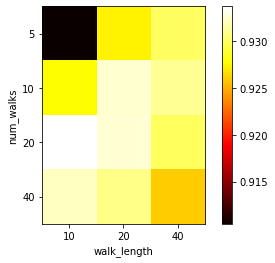

In [16]:
# Deepwalk

plt.figure(figsize=(6, 4))
node_dim = 10

# you should have an auc score dictionary here.
a = np.array([[deepwalk_auc_scores[(node_dim, num_walks, walk_length)] for walk_length in [10, 20, 40]] for num_walks in [5, 10, 20, 40]])
plt.imshow(a, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.xticks(ticks=[0,1,2], labels=[10, 20, 40])
plt.xlabel("walk_length")
plt.yticks(ticks=[0,1,2,3], labels=[5, 10, 20, 40])
plt.ylabel("num_walks")

Text(0, 0.5, 'num_walks')

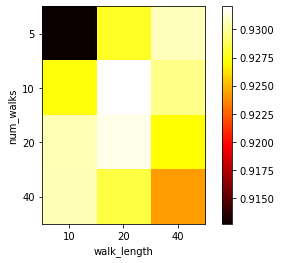

In [34]:
# Node2Vec: num_walks & walk_length

plt.figure(figsize=(6, 4))
node_dim = 10

# you should have an auc score dictionary here.
a = np.array([[node2vec_auc_scores[(node_dim, num_walks, walk_length, p, q)] for walk_length in [10, 20, 40]] for num_walks in [5, 10, 20, 40]])
plt.imshow(a, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.xticks(ticks=[0,1,2], labels=[10, 20, 40])
plt.xlabel("walk_length")
plt.yticks(ticks=[0,1,2,3], labels=[5, 10, 20, 40])
plt.ylabel("num_walks")

Text(0, 0.5, 'p')

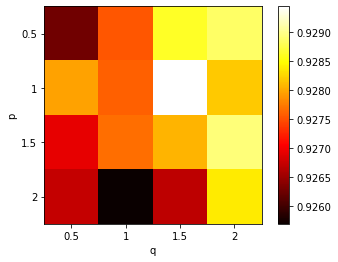

In [32]:
# Node2Vec: p & q

plt.figure(figsize=(6, 4))
node_dim = 10

# you should have an auc score dictionary here.
a = np.array([[node2vec_auc_scores_pq[(node_dim, num_walks, walk_length, p, q)] for q in [0.5, 1, 1.5, 2]] for p in [0.5, 1, 1.5, 2]])
plt.imshow(a, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.xticks(ticks=[0,1,2,3], labels=[0.5, 1, 1.5, 2])
plt.xlabel("q")
plt.yticks(ticks=[0,1,2,3], labels=[0.5, 1, 1.5, 2])
plt.ylabel("p")

Text(0, 0.5, 'p')

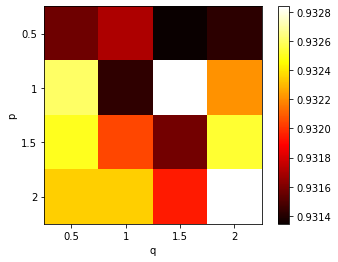

In [36]:
# Node2Vec: p & q with num_walks = 10, walk_length = 20

plt.figure(figsize=(6, 4))
node_dim = 10

# you should have an auc score dictionary here.
a = np.array([[node2vec_auc_scores_pq_2[(node_dim, num_walks, walk_length, p, q)] for q in [0.5, 1, 1.5, 2]] for p in [0.5, 1, 1.5, 2]])
plt.imshow(a, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.xticks(ticks=[0,1,2,3], labels=[0.5, 1, 1.5, 2])
plt.xlabel("q")
plt.yticks(ticks=[0,1,2,3], labels=[0.5, 1, 1.5, 2])
plt.ylabel("p")

You can build model with the best parameters you find and save the prediction here.

In [17]:
# provided

model = build_deepwalk(graph, alias_nodes, node_dim=10, num_walks=10, walk_length=10)
scores = [get_cosine_sim(model, src, dst) for src, dst in test_edges]
write_pred("pred.csv", test_edges, scores)

building a DeepWalk model...	number of walks: 83430	average walk length: 9.8905	training time: 39.4259


In [37]:
# our selected model

model = build_node2vec(graph, alias_nodes, alias_edges, node_dim=10, num_walks=10, walk_length=20, p=1, q=1.5)
scores = [get_cosine_sim(model, src, dst) for src, dst in test_edges]
write_pred("pred.csv", test_edges, scores)

building a node2vec model...	number of walks: 83430	average walk length: 19.9762	training time: 74.5383


With the help of p and q, the node2vec model can fit training data better. And you can have a try if you set p=q=1, the two models will return the same results.